In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 512)               478720    


 dense_1 (Dense)             (None, 256)               131328    


 dense_2 (Dense)             (None, 128)               32896     


 dense_3 (Dense)             (None, 1)                 129       


Total params: 643073 (2.45 MB)


Trainable params: 643073 (2.45 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:09 - loss: 0.1323 - STD: 5.0987e-04 - MAE: 0.3512

 4/64 [>.............................] - ETA: 1s - loss: 0.0498 - STD: 0.0016 - MAE: 0.1712      

 7/64 [==>...........................] - ETA: 1s - loss: 0.0422 - STD: 0.0013 - MAE: 0.1578

 9/64 [===>..........................] - ETA: 4s - loss: 0.0410 - STD: 0.0011 - MAE: 0.1556

12/64 [====>.........................] - ETA: 3s - loss: 0.0379 - STD: 0.0010 - MAE: 0.1495

15/64 [======>.......................] - ETA: 2s - loss: 0.0339 - STD: 0.0010 - MAE: 0.1365

18/64 [=======>......................] - ETA: 2s - loss: 0.0302 - STD: 0.0011 - MAE: 0.1251

21/64 [========>.....................] - ETA: 1s - loss: 0.0281 - STD: 0.0012 - MAE: 0.1224

24/64 [==========>...................] - ETA: 1s - loss: 0.0266 - STD: 0.0013 - MAE: 0.1211

27/64 [===========>..................] - ETA: 1s - loss: 0.0251 - STD: 0.0014 - MAE: 0.1176

30/64 [=============>................] - ETA: 1s - loss: 0.0238 - STD: 0.0015 - MAE: 0.1124

33/64 [==============>...............] - ETA: 1s - loss: 0.0228 - STD: 0.0015 - MAE: 0.1075

36/64 [===============>..............] - ETA: 0s - loss: 0.0220 - STD: 0.0016 - MAE: 0.1035

39/64 [=================>............] - ETA: 0s - loss: 0.0213 - STD: 0.0018 - MAE: 0.1003

42/64 [==================>...........] - ETA: 0s - loss: 0.0207 - STD: 0.0019 - MAE: 0.0981

45/64 [====================>.........] - ETA: 0s - loss: 0.0201 - STD: 0.0021 - MAE: 0.0968

48/64 [=====================>........] - ETA: 0s - loss: 0.0196 - STD: 0.0024 - MAE: 0.0957

51/64 [======================>.......] - ETA: 0s - loss: 0.0191 - STD: 0.0026 - MAE: 0.0943

54/64 [========================>.....] - ETA: 0s - loss: 0.0187 - STD: 0.0029 - MAE: 0.0927

57/64 [=========================>....] - ETA: 0s - loss: 0.0183 - STD: 0.0032 - MAE: 0.0909

60/64 [===========================>..] - ETA: 0s - loss: 0.0179 - STD: 0.0036 - MAE: 0.0894

63/64 [============================>.] - ETA: 0s - loss: 0.0176 - STD: 0.0040 - MAE: 0.0881

64/64 [==============================] - 3s 37ms/step - loss: 0.0175 - STD: 0.0042 - MAE: 0.0878 - val_loss: 0.0140 - val_STD: 0.0117 - val_MAE: 0.0750


Epoch 2/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0106 - STD: 0.0160 - MAE: 0.0667

 4/64 [>.............................] - ETA: 1s - loss: 0.0103 - STD: 0.0175 - MAE: 0.0664

 7/64 [==>...........................] - ETA: 1s - loss: 0.0100 - STD: 0.0192 - MAE: 0.0644

10/64 [===>..........................] - ETA: 1s - loss: 0.0098 - STD: 0.0209 - MAE: 0.0622

14/64 [=====>........................] - ETA: 0s - loss: 0.0095 - STD: 0.0237 - MAE: 0.0601

17/64 [======>.......................] - ETA: 0s - loss: 0.0092 - STD: 0.0261 - MAE: 0.0590

20/64 [========>.....................] - ETA: 0s - loss: 0.0089 - STD: 0.0288 - MAE: 0.0582

23/64 [=========>....................] - ETA: 0s - loss: 0.0086 - STD: 0.0316 - MAE: 0.0572

26/64 [===========>..................] - ETA: 0s - loss: 0.0084 - STD: 0.0344 - MAE: 0.0561

29/64 [============>.................] - ETA: 0s - loss: 0.0081 - STD: 0.0373 - MAE: 0.0551

32/64 [==============>...............] - ETA: 0s - loss: 0.0078 - STD: 0.0402 - MAE: 0.0543

35/64 [===============>..............] - ETA: 0s - loss: 0.0076 - STD: 0.0431 - MAE: 0.0535

38/64 [================>.............] - ETA: 0s - loss: 0.0074 - STD: 0.0457 - MAE: 0.0528

41/64 [==================>...........] - ETA: 0s - loss: 0.0072 - STD: 0.0482 - MAE: 0.0521

44/64 [===================>..........] - ETA: 0s - loss: 0.0070 - STD: 0.0504 - MAE: 0.0514

47/64 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0526 - MAE: 0.0508

50/64 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0545 - MAE: 0.0502

53/64 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0563 - MAE: 0.0496

56/64 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0580 - MAE: 0.0491

59/64 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0595 - MAE: 0.0486

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0481

64/64 [==============================] - 1s 22ms/step - loss: 0.0060 - STD: 0.0618 - MAE: 0.0478 - val_loss: 0.0053 - val_STD: 0.0677 - val_MAE: 0.0447


Epoch 3/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0893 - MAE: 0.0381

 4/64 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0902 - MAE: 0.0383

 7/64 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0909 - MAE: 0.0379

10/64 [===>..........................] - ETA: 0s - loss: 0.0035 - STD: 0.0912 - MAE: 0.0378

13/64 [=====>........................] - ETA: 0s - loss: 0.0034 - STD: 0.0917 - MAE: 0.0376

16/64 [======>.......................] - ETA: 0s - loss: 0.0034 - STD: 0.0922 - MAE: 0.0375

19/64 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0924 - MAE: 0.0373

22/64 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0927 - MAE: 0.0372

25/64 [==========>...................] - ETA: 0s - loss: 0.0033 - STD: 0.0932 - MAE: 0.0371

29/64 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0932 - MAE: 0.0369

32/64 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0935 - MAE: 0.0368

35/64 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0937 - MAE: 0.0367

38/64 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0937 - MAE: 0.0366

41/64 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0940 - MAE: 0.0365

44/64 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0941 - MAE: 0.0364

47/64 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0942 - MAE: 0.0363

50/64 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0943 - MAE: 0.0362

53/64 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0944 - MAE: 0.0361

56/64 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0945 - MAE: 0.0360

59/64 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0947 - MAE: 0.0359

62/64 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0948 - MAE: 0.0358

64/64 [==============================] - 1s 22ms/step - loss: 0.0031 - STD: 0.0948 - MAE: 0.0358 - val_loss: 0.0038 - val_STD: 0.0767 - val_MAE: 0.0392


Epoch 4/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0985 - MAE: 0.0341

 4/64 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.0983 - MAE: 0.0336

 7/64 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.0976 - MAE: 0.0336

10/64 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.0983 - MAE: 0.0337

13/64 [=====>........................] - ETA: 0s - loss: 0.0026 - STD: 0.0981 - MAE: 0.0336

16/64 [======>.......................] - ETA: 0s - loss: 0.0026 - STD: 0.0981 - MAE: 0.0335

19/64 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.0983 - MAE: 0.0335

22/64 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.0980 - MAE: 0.0334

25/64 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.0984 - MAE: 0.0334

28/64 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.0984 - MAE: 0.0333

31/64 [=============>................] - ETA: 0s - loss: 0.0026 - STD: 0.0984 - MAE: 0.0332

34/64 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0984 - MAE: 0.0331

37/64 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0985 - MAE: 0.0331

40/64 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0986 - MAE: 0.0330

43/64 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0986 - MAE: 0.0329

46/64 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0988 - MAE: 0.0329

49/64 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0989 - MAE: 0.0328

53/64 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0991 - MAE: 0.0327

56/64 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0991 - MAE: 0.0327

59/64 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0991 - MAE: 0.0326

62/64 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0991 - MAE: 0.0325

64/64 [==============================] - 1s 21ms/step - loss: 0.0024 - STD: 0.0992 - MAE: 0.0325 - val_loss: 0.0027 - val_STD: 0.0827 - val_MAE: 0.0348


Epoch 5/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1046 - MAE: 0.0312

 3/64 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.1008 - MAE: 0.0312

 6/64 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.1016 - MAE: 0.0311

 9/64 [===>..........................] - ETA: 1s - loss: 0.0021 - STD: 0.1012 - MAE: 0.0310

12/64 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.1014 - MAE: 0.0310

15/64 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1013 - MAE: 0.0309

18/64 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.1010 - MAE: 0.0309

21/64 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1011 - MAE: 0.0308

24/64 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1010 - MAE: 0.0307

27/64 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.1012 - MAE: 0.0307

30/64 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1013 - MAE: 0.0306

34/64 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1014 - MAE: 0.0306

37/64 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.1013 - MAE: 0.0305

40/64 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1014 - MAE: 0.0305

43/64 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0304

46/64 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0304

49/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0304

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0303

55/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0303

58/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0302

61/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0302

64/64 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1017 - MAE: 0.0302

64/64 [==============================] - 1s 21ms/step - loss: 0.0020 - STD: 0.1017 - MAE: 0.0302 - val_loss: 0.0022 - val_STD: 0.0902 - val_MAE: 0.0323


Epoch 6/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0293

 4/64 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.1027 - MAE: 0.0296

 7/64 [==>...........................] - ETA: 1s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0295

10/64 [===>..........................] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0294

13/64 [=====>........................] - ETA: 0s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0293

16/64 [======>.......................] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0293

19/64 [=======>......................] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0293

22/64 [=========>....................] - ETA: 0s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0293

25/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0292

28/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0292

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0291

34/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0291

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0291

40/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0291

43/64 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0290

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0290

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0290

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0290

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0290

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0290

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0289

64/64 [==============================] - 1s 21ms/step - loss: 0.0018 - STD: 0.1033 - MAE: 0.0289 - val_loss: 0.0020 - val_STD: 0.0926 - val_MAE: 0.0304


Epoch 7/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

 4/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0284

 7/64 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

10/64 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

13/64 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0283

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0284

19/64 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

28/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0282

34/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0282

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0282

40/64 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0282

43/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0282

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

64/64 [==============================] - 1s 21ms/step - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280 - val_loss: 0.0019 - val_STD: 0.0950 - val_MAE: 0.0299


Epoch 8/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0277

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0276

10/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0276

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0276

16/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

19/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0276

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0277

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

64/64 [==============================] - 1s 21ms/step - loss: 0.0016 - STD: 0.1046 - MAE: 0.0275 - val_loss: 0.0019 - val_STD: 0.0956 - val_MAE: 0.0294


Epoch 9/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0279

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0274

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0274

10/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

16/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

19/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

64/64 [==============================] - 1s 21ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270 - val_loss: 0.0017 - val_STD: 0.0949 - val_MAE: 0.0285


Epoch 10/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0269

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

20/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

32/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

35/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

64/64 [==============================] - 1s 21ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268 - val_loss: 0.0018 - val_STD: 0.0965 - val_MAE: 0.0291


Epoch 11/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

19/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

64/64 [==============================] - 1s 21ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265 - val_loss: 0.0018 - val_STD: 0.0973 - val_MAE: 0.0292


Epoch 12/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0267

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0264

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

19/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - 1s 21ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265 - val_loss: 0.0018 - val_STD: 0.0969 - val_MAE: 0.0294


Epoch 13/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0262

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0261

16/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0261

19/64 [=======>......................] - ETA: 0s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0262

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

64/64 [==============================] - 1s 21ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261 - val_loss: 0.0016 - val_STD: 0.0960 - val_MAE: 0.0278


Epoch 14/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1041 - MAE: 0.0261

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0261

10/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0262

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0263

16/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

19/64 [=======>......................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

23/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

26/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

64/64 [==============================] - 1s 20ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261 - val_loss: 0.0016 - val_STD: 0.0965 - val_MAE: 0.0280


Epoch 15/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0263

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0262

20/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0263

23/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0263

26/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0263

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0262

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0262

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0262

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0262

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

64/64 [==============================] - 1s 21ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261 - val_loss: 0.0016 - val_STD: 0.0959 - val_MAE: 0.0275


Epoch 16/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1000 - MAE: 0.0263

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1038 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

10/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

16/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0259

19/64 [=======>......................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

22/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

64/64 [==============================] - 1s 21ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266 - val_loss: 0.0018 - val_STD: 0.0986 - val_MAE: 0.0294


Epoch 17/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0258

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0259

10/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

14/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

20/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

23/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

26/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

64/64 [==============================] - 1s 21ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257 - val_loss: 0.0017 - val_STD: 0.0981 - val_MAE: 0.0286


Epoch 18/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0254

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

 8/64 [==>...........................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

11/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

14/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

20/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

23/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

26/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - 1s 21ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256 - val_loss: 0.0018 - val_STD: 0.0992 - val_MAE: 0.0290


Epoch 19/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1108 - MAE: 0.0257

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

16/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

19/64 [=======>......................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

22/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

64/64 [==============================] - 1s 21ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255 - val_loss: 0.0017 - val_STD: 0.0982 - val_MAE: 0.0283


Epoch 20/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0259

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

11/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

14/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

20/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

23/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

26/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

64/64 [==============================] - 1s 21ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256 - val_loss: 0.0017 - val_STD: 0.0982 - val_MAE: 0.0282


Epoch 21/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1085 - MAE: 0.0253

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0253

11/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

14/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

20/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

23/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

26/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

64/64 [==============================] - 1s 21ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255 - val_loss: 0.0017 - val_STD: 0.0992 - val_MAE: 0.0285


Epoch 22/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0253

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0251

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

11/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

14/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

20/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0254

23/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

26/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

32/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

35/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

44/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

64/64 [==============================] - 1s 20ms/step - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253 - val_loss: 0.0019 - val_STD: 0.1006 - val_MAE: 0.0294


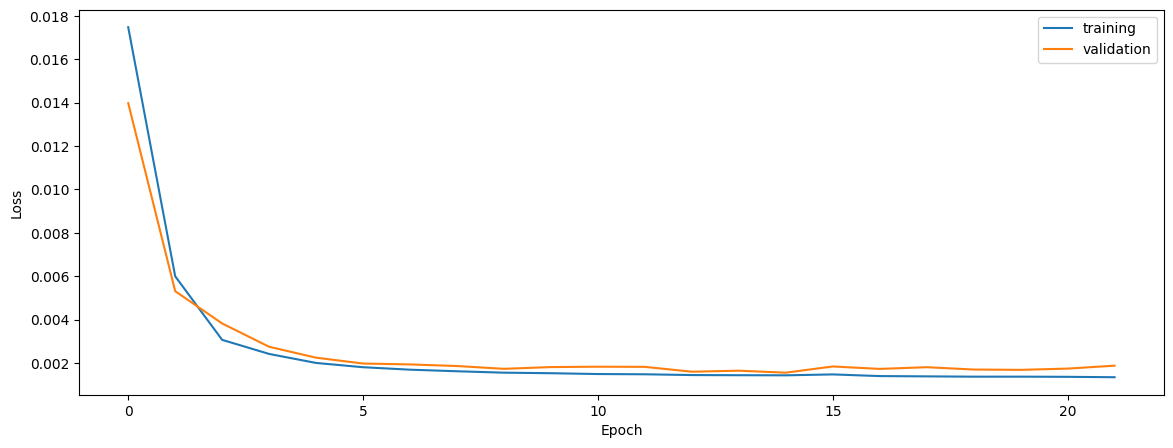

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9431212476875829
0.9537719726159849
0.9493910722189229


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9438761311418747
0.9515971696515045
0.9504483727897842


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9508795252475921
0.9538714790779946
0.9623980612269221


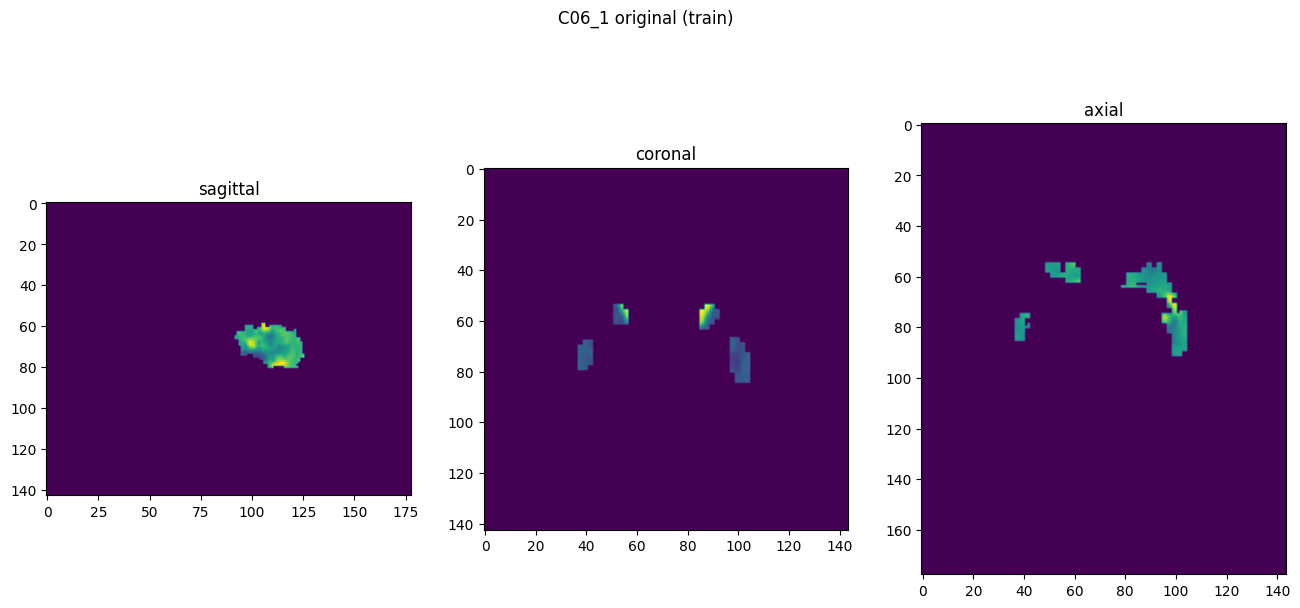

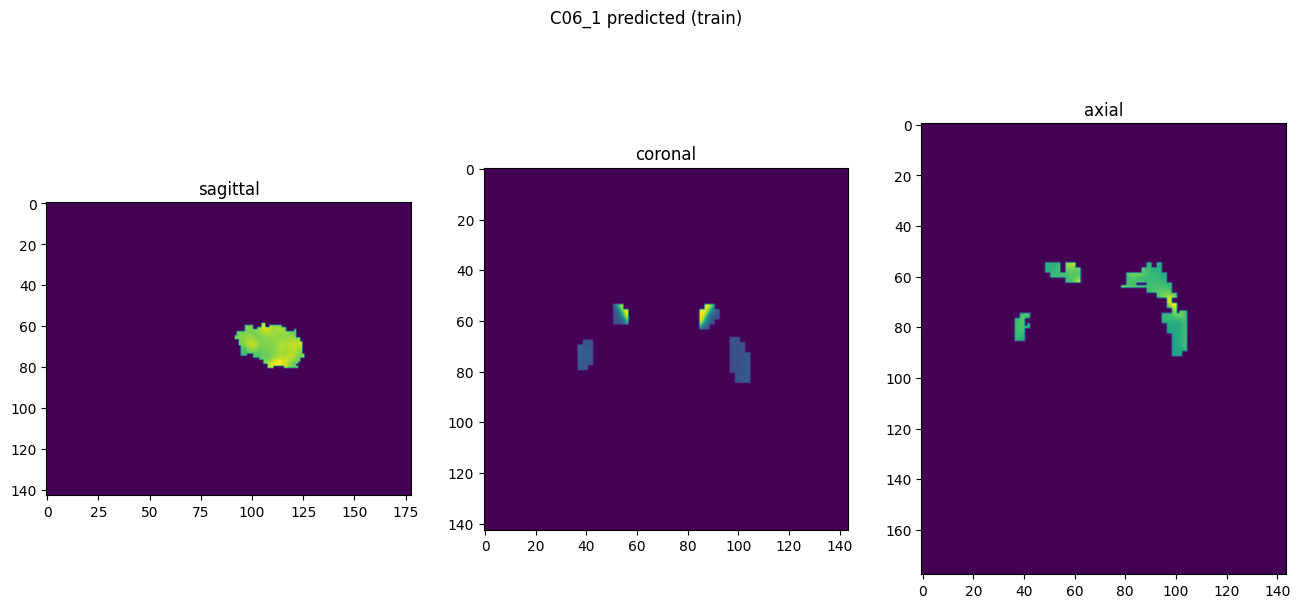

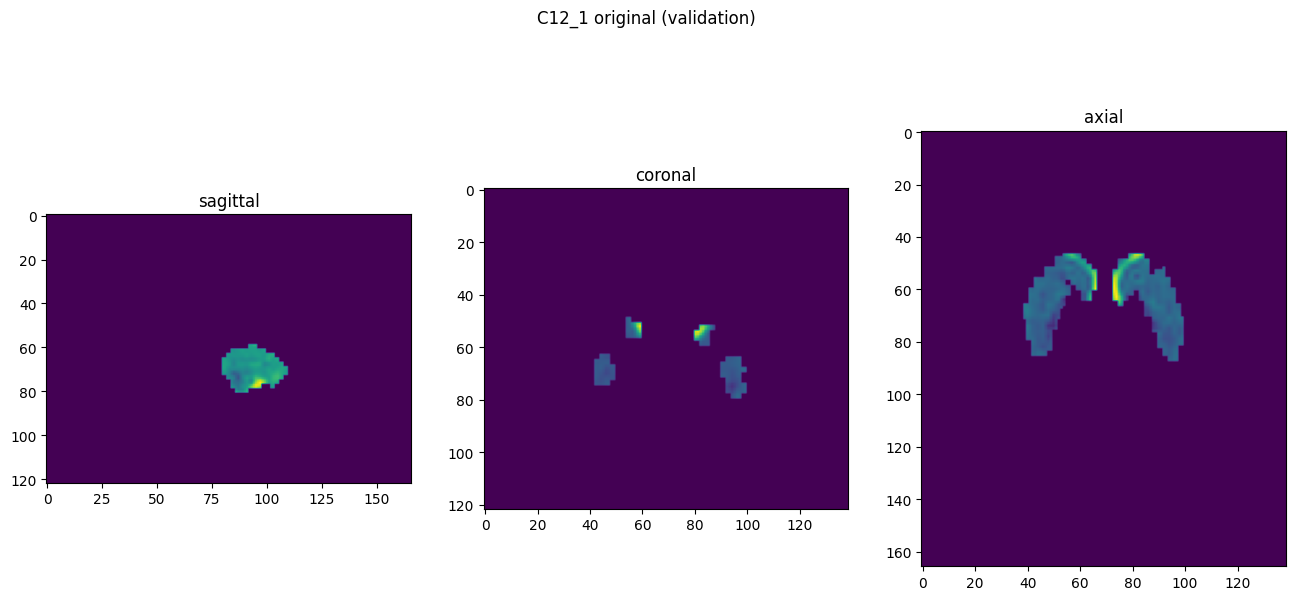

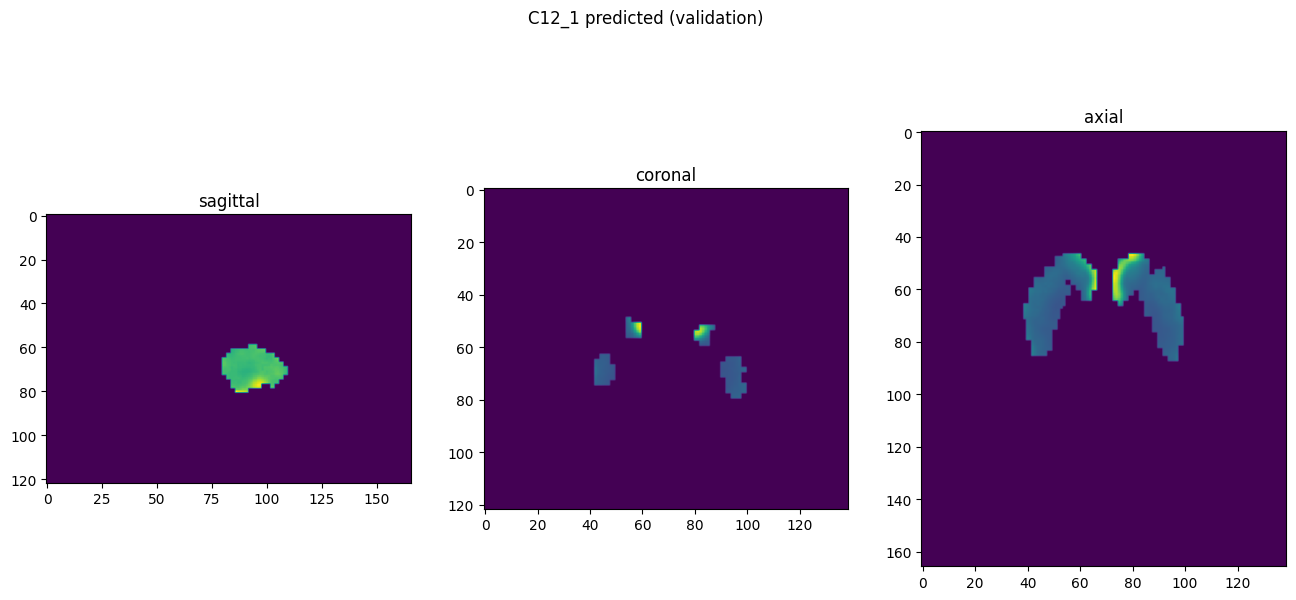

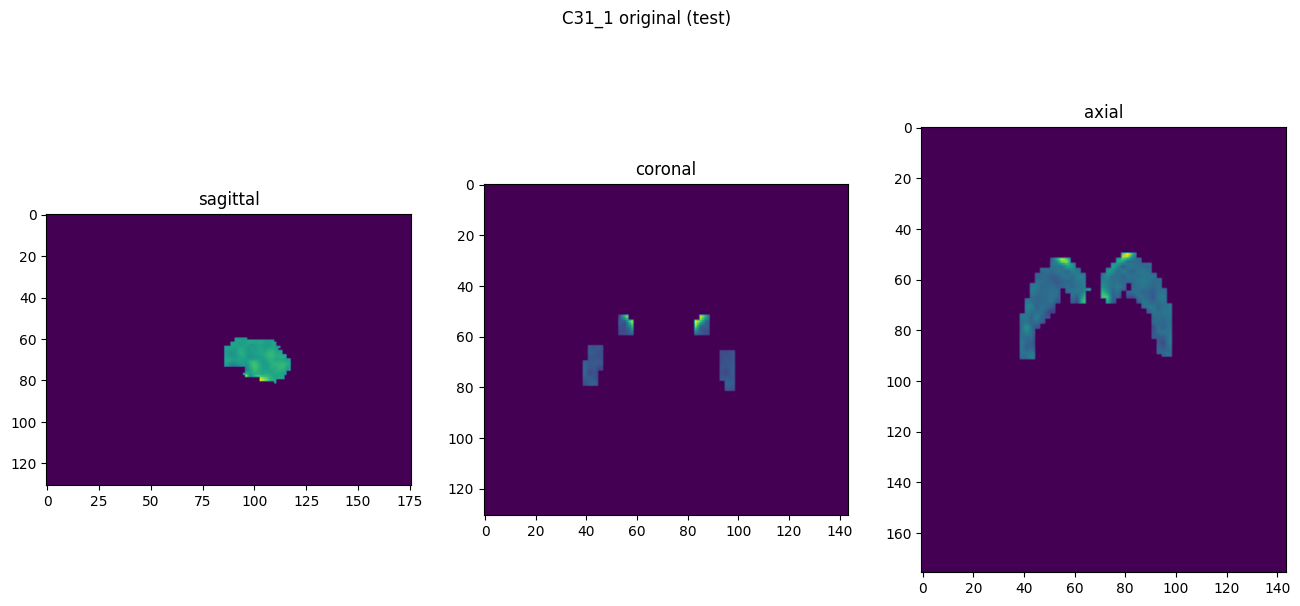

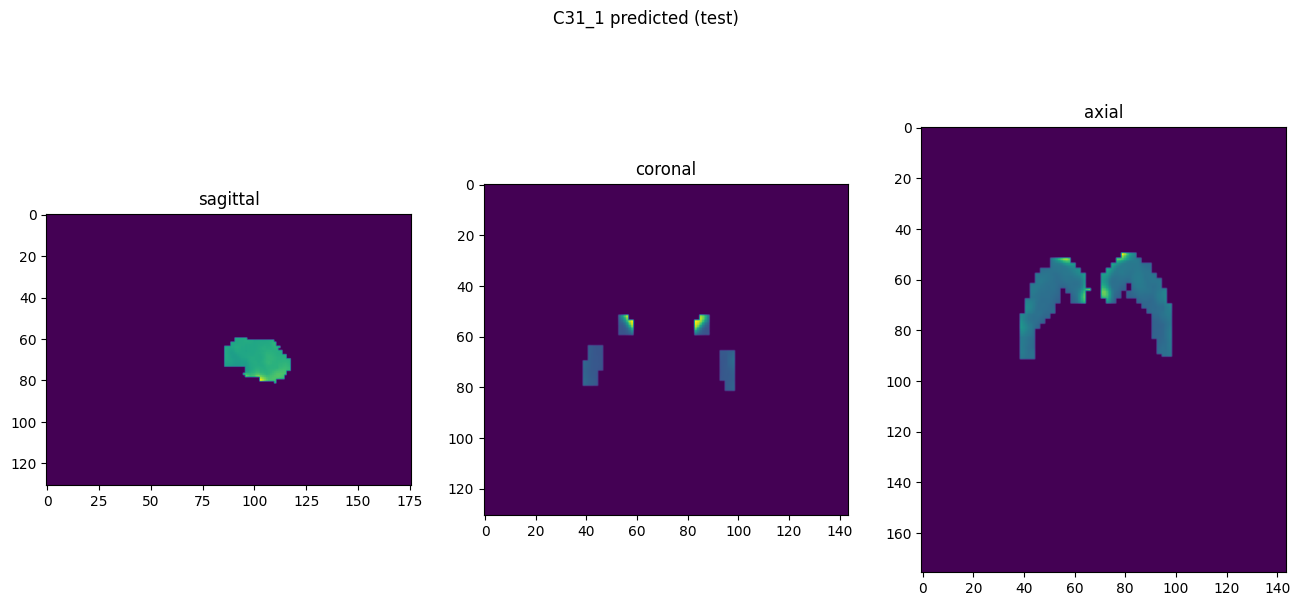

In [10]:
showResults(model, gen, threshold=None, background=False)